In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## 1. Чтение данных


Загружаем датасет из репозитория GitHub https://github.com/ArtyomGi/MachineLearning

In [24]:
url = 'https://raw.githubusercontent.com/ArtyomGi/MachineLearning/main/MLP.csv'
data_raw = pd.read_csv(url)

In [25]:
data_raw["Boxoffice"] = data_raw["Boxoffice"].apply(lambda v: float(str(v).replace(",", "").replace("$", "")))
data_raw["binary_boxoffice"] = np.where(data_raw["Boxoffice"] >= 1000000, 1, 0) # заменим 1 все суммы, которые >= 1000000, а 0 все остальные
data_raw.drop(['Netflix Link', 'IMDb Link', 'Summary', 'Image', 'Poster', 'TMDb Trailer', 'Trailer Site'], axis=1, inplace = True)

## 2. Предобработка
Выполняется аналогично первой лабораторной работе

Преобразуем номинальные признаки в специальный категориальный тип. Сейчас они имеют тип объекта.

In [26]:
data_raw['Series or Movie'] = data_raw['Series or Movie'].astype('category')
data_raw['Runtime'] = data_raw['Runtime'].astype('category')

### Обработаем пропущенные значения

In [27]:
data_raw.fillna(data_raw.median(axis = 0), axis = 0 , inplace=True)

data_raw['Genre'].fillna(data_raw['Genre'].mode().iloc[0], inplace=True)
data_raw['Tags'].fillna(data_raw['Tags'].mode().iloc[0], inplace=True)
data_raw['Languages'].fillna(data_raw['Languages'].mode().iloc[0], inplace=True)
data_raw['Country Availability'].fillna(data_raw['Country Availability'].mode().iloc[0], inplace=True)
data_raw['Runtime'].fillna(data_raw['Runtime'].mode().iloc[0], inplace=True)
data_raw['Director'].fillna(data_raw['Director'].mode().iloc[0], inplace=True)
data_raw['Writer'].fillna(data_raw['Writer'].mode().iloc[0], inplace=True)
data_raw['Actors'].fillna(data_raw['Actors'].mode().iloc[0], inplace=True)
data_raw['View Rating'].fillna(data_raw['View Rating'].mode().iloc[0], inplace=True)
data_raw['Release Date'].fillna(data_raw['Release Date'].mode().iloc[0], inplace=True)
data_raw['Production House'].fillna(data_raw['Production House'].mode().iloc[0], inplace=True)

### Обработаем категориальные признаки

In [28]:
data_new = data_raw.loc[:, ['Series or Movie', 'Hidden Gem Score', 'Runtime',
                            'Rotten Tomatoes Score', 'Metacritic Score', 'Awards Received', 'Awards Nominated For',
                            'IMDb Votes', 'binary_boxoffice']].copy()

data_new['Series or Movie'] = pd.factorize(data_new['Series or Movie'])[0]

Runtime_dummies = pd.get_dummies(data_new['Runtime'])
data_new = pd.concat((data_new, Runtime_dummies), axis=1)
data_new = data_new.drop(['Runtime'], axis=1)

### Нормализуем признаки

Нормализуем признаки при помощи линейного преобразования к отрезку [0, 1]:

In [29]:
data_normalized = (data_new - data_new.min(axis=0)) / (data_new.max(axis=0) - data_new.min(axis=0))

# 3. Разбивка данных на обучающие и тестовые признаки

Выделяем целевой столбец из таблицы:

In [30]:
X = data_normalized.drop(['binary_boxoffice'], axis = 1)
y = data_normalized['binary_boxoffice']

Разбиваем данные на обучающую и тестовую выборки в соотношении 3:1, т.е. в обучающую выборку попадет 75% объектов, в тестовую 25%

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 97)

N_train = X_train.shape[0]
N_test = X_test.shape[0]
N_train, N_test

(11610, 3870)

# 4. Обучение классификатора MLP

In [32]:
mlp = MLPClassifier(hidden_layer_sizes=(2,), solver="lbfgs", activation="logistic", random_state=190)
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(2,), random_state=190,
              solver='lbfgs')

Вычислим точность полученного классификатора

In [33]:
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)
print("Train: {}, Test: {}".format(
    accuracy_score(y_train, y_train_pred),
    accuracy_score(y_test, y_test_pred)
))

Train: 0.9351421188630491, Test: 0.9343669250645995


# 5. Подбор гиперпараметров

## Подбор параметра регуляризации

Подберем оптимальное значение параметра регуляризации $\alpha$

In [34]:
alpha_arr = np.logspace(-3, 2.5, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in tqdm(alpha_arr):
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (2,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.21it/s]


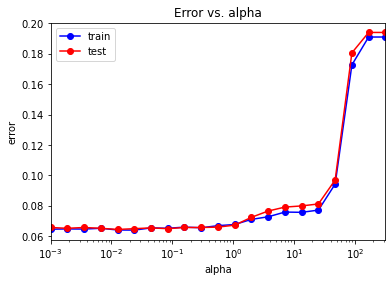

In [35]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

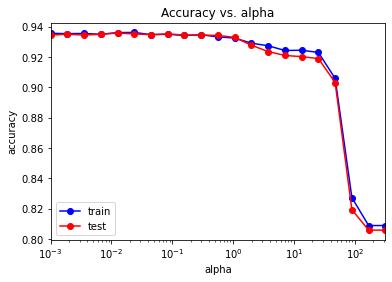

In [36]:
plt.semilogx(alpha_arr, train_acc, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.legend()
pass

Из графиков видно, что большие значения $\alpha$ ($\alpha > 50$) приводят к недообучению нейронной сети. Точность на таких $\alpha$ значительно падает

В окрестности нуля наблюдается наименьшее отклонение в значениях точности на обучающей выборке и на тестовой выборке. При этом в этой окрестности точность одна из максимальных на всем графике

Минимальное значение ошибки:

In [37]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.06391042204995694 0.06434108527131784


Найдем оптимальное значение $\alpha$:

In [38]:
alpha_opt = alpha_arr[test_err == min_test_err][0]
print(alpha_opt)


0.012589254117941675


## Классификатор с найденным оптимальным числом $\alpha$

In [39]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes=(2,), solver="lbfgs",
                          activation="logistic", random_state=190)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print("Train: {}, Test: {}".format(
    accuracy_score(y_train, y_train_pred),
    accuracy_score(y_test, y_test_pred)
))

Train: 0.9342807924203274, Test: 0.9335917312661499


## Матрица рассогласования

In [40]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[2996  134]
 [ 123  617]]


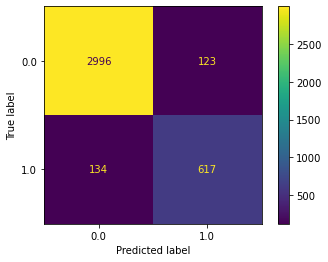

In [41]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp_model, X_test, y_test)
pass

## Подбор числа нейронов

In [45]:
hidden_layer_size = np.linspace(1, 100, 10).astype(int)
test_err, train_err = [], []
train_acc, test_acc = [], []

for size in tqdm(hidden_layer_size):
    model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes=(size,),
                          max_iter=3000, solver="lbfgs", activation="logistic", random_state=190)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:33<00:00, 57.38s/it]


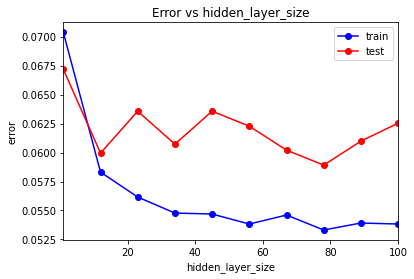

In [51]:
plt.plot(hidden_layer_size, train_err, 'b-o', label = 'train')
plt.plot(hidden_layer_size, test_err, 'r-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Error vs hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('error')
plt.legend()
pass

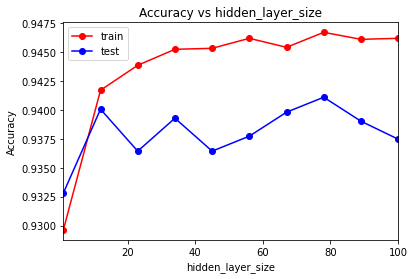

In [49]:
plt.plot(hidden_layer_size, train_acc, 'r-o', label = 'train')
plt.plot(hidden_layer_size, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Accuracy vs hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('Accuracy')
plt.legend()
pass

Оптимальное значение числа нейронов около 10. В нейросети, содержащей менее 10 нейронов, точность на выборках относительно низкая. При дальнейшем увеличении числа нейронов более 10 происходит переобучение, точность на обучающей выборке резко растет, в то же время на обучающей выборке на некоторых участках точность снижается.

# 6. Общие выводы

#### 1. Подбор параметра регуляризации

Исходя из графиков зависимости ошибки и точности от параметра регуляризации видно, что на значениях $\alpha < 0$ переобучения у нейронной сети не возникает. Однако на значениях параметра $0 < \alpha < 50$ наблюдается незначительное переобучение. Ошибка на тестовой выборке превышает ошибку на обучающей. При параметре $\alpha > 50$ наблюдается сильное недообучение модели - возрастает ошибка, падает точность

Оптимальное значение $\alpha = 0.01258$.

#### 2. Подбор числа нейронов при найденном $\alpha$

На графиках зависимости ошибки и точности от числа нейронов в нейросети можно наблюдать переобучение при значениях больших 10. Ошибка на некоторых участках тестовой выборки растет, точность соответственно падает. При этом на обучающей выборке точность резко растет. На значениях числа нейронов менее 10 точность на обучающей и тестовой выборках падает.

Оптимальное значение числа нейронов 10.